<a href="https://colab.research.google.com/github/UO294665/AAIM/blob/main/google_colab_files/05_Clustering_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data description**¶

There are 77 expression levels of proteins/protein modifications (columns) that produce detectable signals in the nuclear cortex of Ts65Dn trisomic mice. These proteins are related to a functional hippocampus (learning and memory). In this data there are 38 control mice and 34 trisomic mice (Down syndrome), having 72 mice in total. 15 measurements were carried out for each protein per mouse/sample. In total 570 measurements accounted for control mice and 510 for trisomic mice, having 1080 independent measurements per protein. Some of the values are empty.

**Type of data**
This data set is multi-levelled as is describing 8 classes of mice in function of genotype, behaviour and treatment. According to genotype, we have control (c) and trisomic (t) mice. If we talk about behaviour, some mice have been stimulated to learn (CS) and others have not (SC). According to treatment, some mice have been treated with the drug memantine (m) to assess the ability of the drug in the learning process and others with saline solution (s). The aim is to identify subsets of proteins that are discriminant between the classes.

Classes:
c-CS-s: control mice, stimulated to learn, injected with saline (9 mice)
c-CS-m: control mice, stimulated to learn, injected with memantine (10 mice)
c-SC-s: control mice, not stimulated to learn, injected with saline (9 mice)
c-SC-m: control mice, not stimulated to learn, injected with memantine (10 mice)

t-CS-s: trisomy mice, stimulated to learn, injected with saline (7 mice)

t-CS-m: trisomy mice, stimulated to learn, injected with memantine (9 mice)
t-SC-s: trisomy mice, not stimulated to learn, injected with saline (9 mice)
t-SC-m: trisomy mice, not stimulated to learn, injected with memantine (9 mice)

In [19]:
# Importing Libraries
import pandas as pd # data structure
import matplotlib.pyplot as plt # Plotting purpose
import numpy as np # Numerical computations
import seaborn as sns; sns.set(color_codes=True)  # for plot styling
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster # for dendrogram computation and plotting "linkage" function will be used agglomerative clustering
from sklearn.decomposition import PCA  # Principal component analysis
from sklearn.cluster import KMeans, AgglomerativeClustering  # CLustering methods
from sklearn import preprocessing #for normalization of features

In [4]:
!pip install xlrd # for reading and formatting data from excel (xls) files

In [5]:
# Reading data
data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls", header = 0)
data.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


In [6]:
# Data Cleaning
data = data.dropna()  # Dropping null, and NaNs (Not a number)
data = data.drop(['Behavior','Genotype','MouseID','Treatment'], axis=1) # Dropping irrelevant fields from the dataset
data.head() # Printing first 5 columns to see the data in the dataframe

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,class
75,0.649781,0.828696,0.405862,2.921435,5.167979,0.207174,0.176640,3.728084,0.239283,1.666579,...,0.139052,0.112926,0.132001,0.129363,0.486912,0.125152,0.146865,0.143517,1.627181,c-CS-m
76,0.616481,0.841974,0.388584,2.862575,5.194163,0.223433,0.167725,3.648240,0.221030,1.565150,...,0.133787,0.121607,0.139008,0.143084,0.467833,0.112857,0.161132,0.145719,1.562096,c-CS-m
77,0.637424,0.852882,0.400561,2.968155,5.350820,0.208790,0.173261,3.814545,0.222300,1.741732,...,0.142324,0.130261,0.134804,0.147673,0.462501,0.116433,0.160594,0.142879,1.571868,c-CS-m
78,0.576815,0.755390,0.348346,2.624901,4.727509,0.205892,0.161192,3.778530,0.194153,1.505475,...,0.133637,0.107321,0.118982,0.121290,0.479110,0.102831,0.144238,0.141681,1.646608,c-CS-m
79,0.542545,0.757917,0.350051,2.634509,4.735602,0.210526,0.165671,3.871971,0.194297,1.531613,...,0.133358,0.112851,0.128635,0.142617,0.438354,0.110614,0.155667,0.146408,1.607631,c-CS-m


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


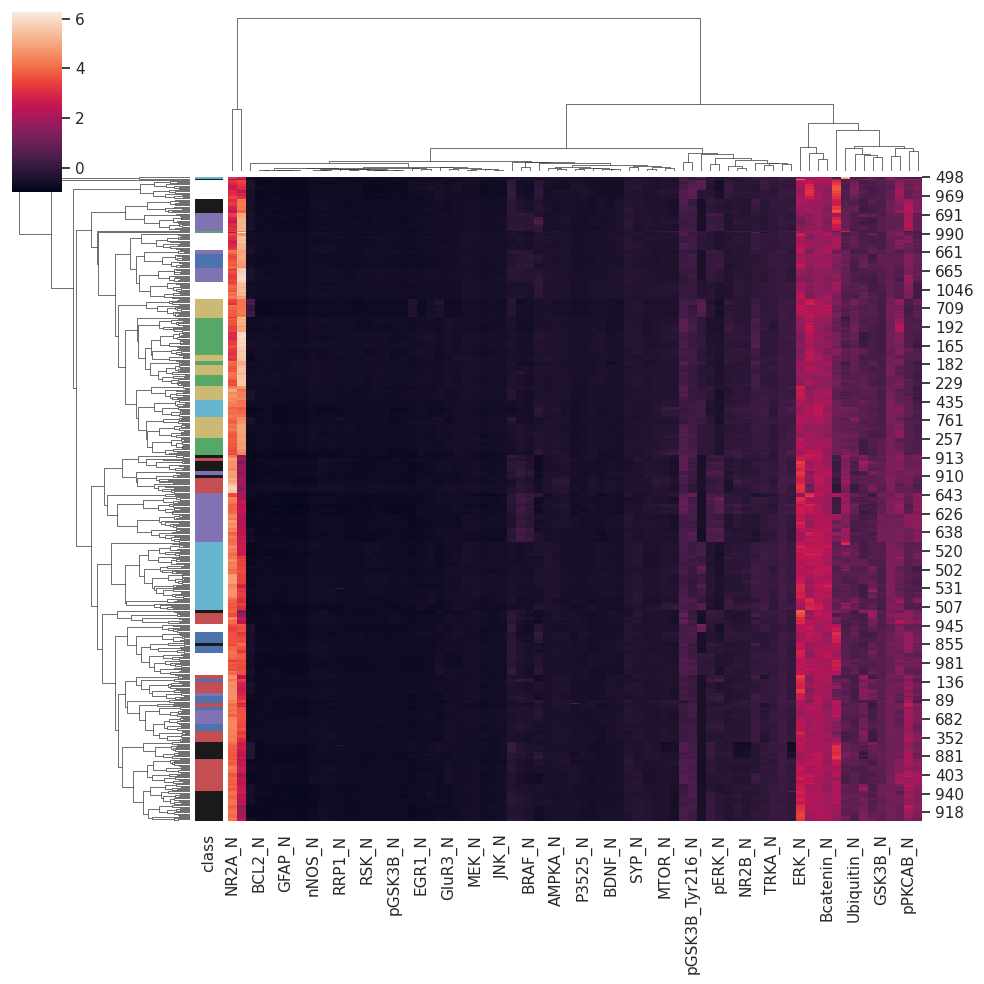

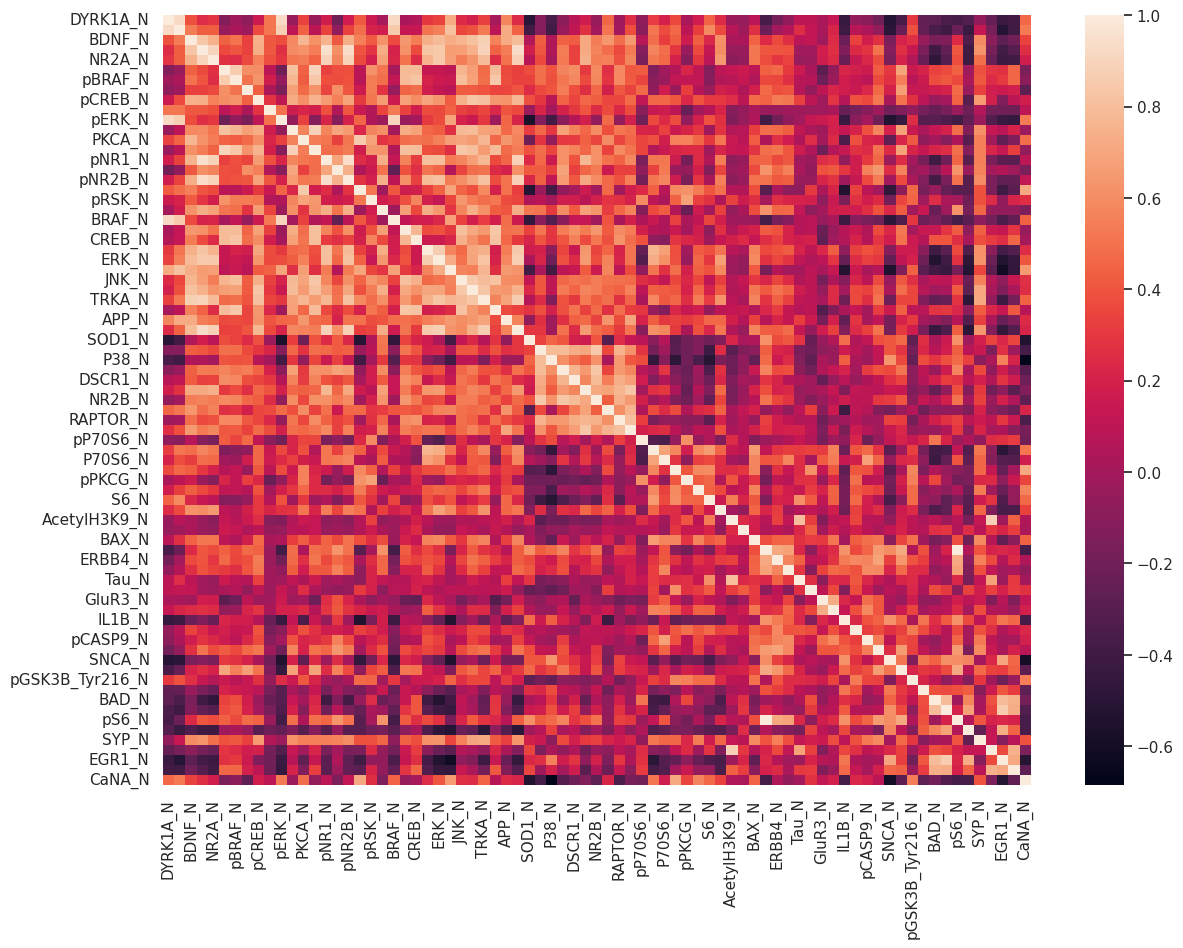

In [7]:
sample = data.pop('class') # extracting the class colum from the dataset to extract the number of classes

#Creating a colour palette for the dendrogram
lut = dict(zip(sample.unique(),'bgrcmykw'))
row_colors = sample.map(lut)
row_colors.head()

#Creating a dendrogram with heatmap to visualise data
data_a = pd.DataFrame(data)
g = sns.clustermap(data_a,row_colors=row_colors, z_score=0,)

#Scaling data  to graph a heat map in terms of correlation coefficient
data_s = preprocessing.scale(data)
data_s = pd.DataFrame(data)

#Correlation matrix and heatmap
data_s.corr()
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
ax=sns.heatmap(data_s.corr()) # showing correlation from the heatmap

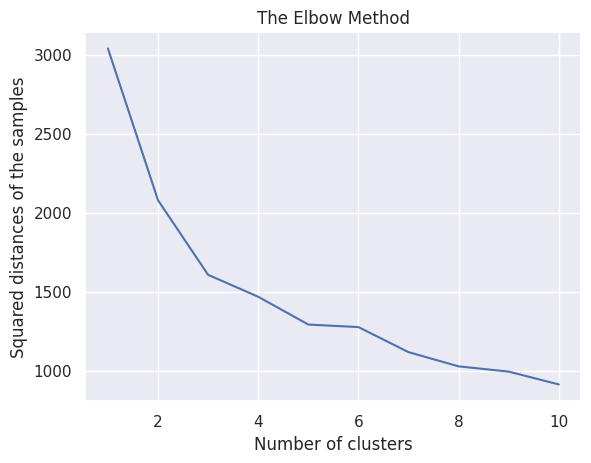

In [8]:
# finding the suitable number of clusters from the data
wcss = [] #  squared distances of the samples
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    #kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data) # Fitting data for clustering
    wcss.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Squared distances of the samples')
plt.show()

**Dimensionality Reduction using Principal Component Analysis**

In [9]:
pca=PCA(n_components=2) # just 2 components for simplicity

#Fit PCA to the dataset (only variables, excluding class)
pca.fit(data)

#Calculating rotated PCA scores
datatrans=pca.transform(data)
classes=sample

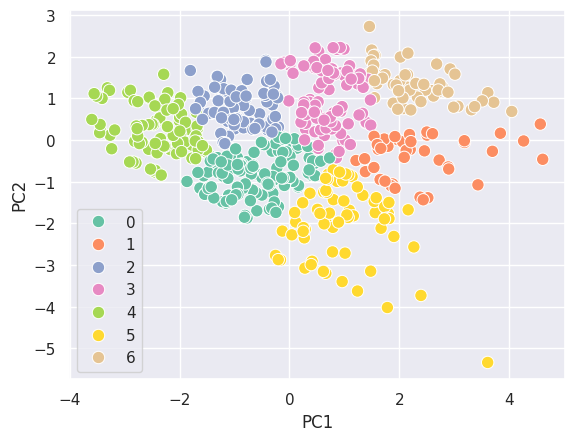

In [10]:
# K-means clustering for PC components
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
pred_kmeans = kmeans.fit_predict(datatrans)
#pred_kmeans = pred_kmeans+1

plt.figure()
sns.scatterplot(x=datatrans[:, 0], y=datatrans[:, 1], hue=pred_kmeans,  palette="Set2", s=80)
#plt.scatter(datatrans[:,0],datatrans[:,1],c=pred_kmeans)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

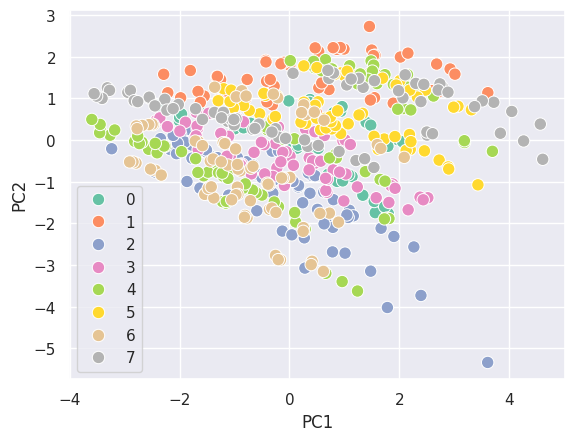

In [11]:
# Ground truth
plt.figure()
classes=pd.factorize(classes) # converting classes to numerics
sns.scatterplot(x=datatrans[:, 0], y=datatrans[:, 1], hue=classes[0], palette="Set2", s=80)
#plt.scatter(datatrans[:,0],datatrans[:,1],c=classes[0])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

** Agglomerative Clustering**

In [23]:
datatrans1=pd.DataFrame(datatrans) # To store the predictions along with the data.
datatrans1.head()
hierarchical_clustering = AgglomerativeClustering(n_clusters=7)
datatrans1["Hierarchical_Cluster"]= hierarchical_clustering.fit_predict(datatrans)

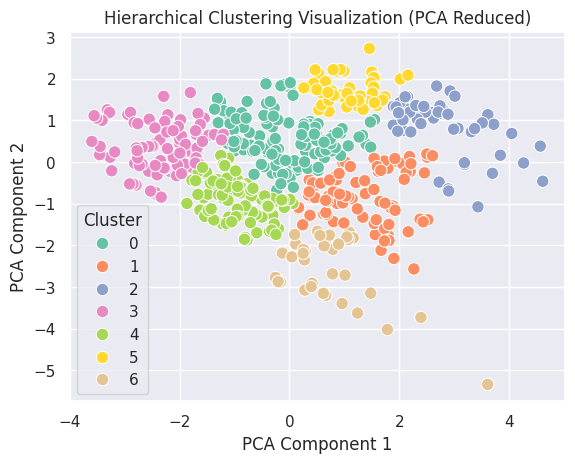

In [24]:

#plt.figure(figsize=(10, 5))
sns.scatterplot(x=datatrans[:, 0], y=datatrans[:, 1], hue=datatrans1["Hierarchical_Cluster"], palette="Set2", s=80)
plt.title("Hierarchical Clustering Visualization (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

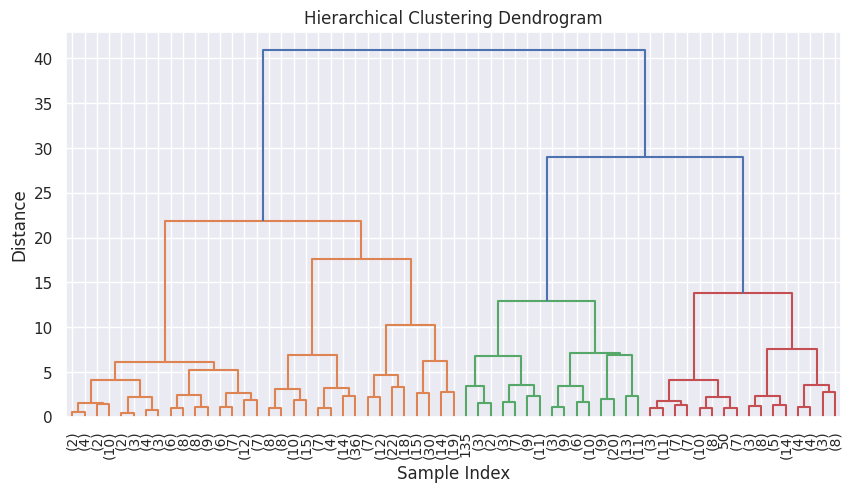

In [25]:
linkage_matrix_pca = linkage(datatrans, method='ward')  # Creating a linkage matrix to create a dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_pca, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

**Performance comparison**

In [26]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# Compute Metrics
# The higher the better- Higher value means accurate location of points in a particular cluster
print("K-Means Silhouette Score:", silhouette_score(datatrans, pred_kmeans))
print("Agglomerative Silhouette Score:", silhouette_score(datatrans, datatrans1["Hierarchical_Cluster"].values))

# The lower the better- Average similarity between each cluster and its similar cluster
print("K-Means Davies-Bouldin Index:", davies_bouldin_score(datatrans, pred_kmeans))
print("Agglomerative Davies-Bouldin Index:", davies_bouldin_score(datatrans, datatrans1["Hierarchical_Cluster"].values))

# The higher the better-Measures the ratio of between-cluster variance to within-cluster variance.
print("K-Means Calinski-Harabasz Index:", calinski_harabasz_score(datatrans, pred_kmeans))
print("Agglomerative Calinski-Harabasz Index:", calinski_harabasz_score(datatrans, datatrans1["Hierarchical_Cluster"].values))

K-Means Silhouette Score: 0.35062290621553477
Agglomerative Silhouette Score: 0.34546318198467346
K-Means Davies-Bouldin Index: 0.8618117818451779
Agglomerative Davies-Bouldin Index: 0.8546194160299418
K-Means Calinski-Harabasz Index: 442.46043495823557
Agglomerative Calinski-Harabasz Index: 426.9280464251937


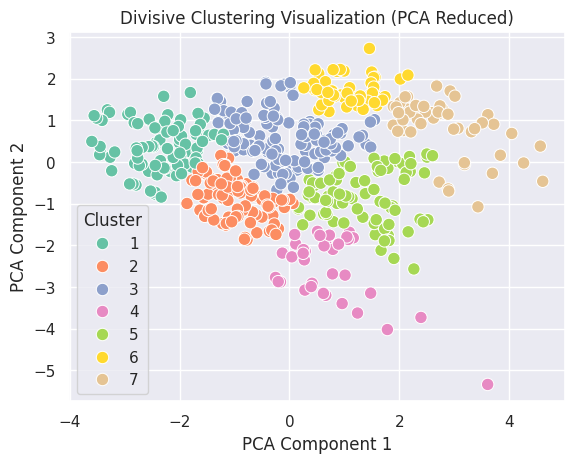

In [29]:
# Convert data into DataFrame
datatrans1 = pd.DataFrame(datatrans)

# Perform hierarchical clustering (Ward's method) for divisive clustering
linkage_matrix_pca = linkage(datatrans, method='ward')

# Cutting the dendrogram to get the desired number of clusters (Divisive approach)
n_clusters = 7
datatrans1["Divisive_Cluster"] = fcluster(linkage_matrix_pca, n_clusters, criterion='maxclust')

# Scatter plot visualization
sns.scatterplot(x=datatrans[:, 0], y=datatrans[:, 1], hue=datatrans1["Divisive_Cluster"], palette="Set2", s=80)
plt.title("Divisive Clustering Visualization (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

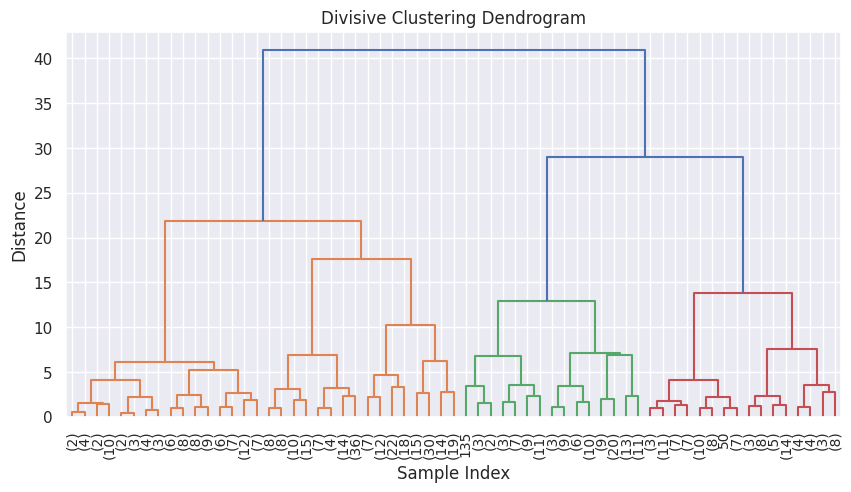

In [28]:
# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_pca, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=10)
plt.title("Divisive Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()